In [1]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   --------------- ------------------------ 4.2/10.7 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 29.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.4 MB ? eta -:--:--
   --------- ------------------------------ 8.9/38.4 MB 46.0 MB/s eta 0:00:01
   --------------------- ------------------ 20.2/38.4 MB 49.0 MB/s eta 0:00:01
   ------------------------------- -------- 30.7/38.4 MB 48.7 MB/s eta 0:00:01
   ---------------------------------------  38.3/38.4 MB 45.9 MB/s eta 0:00:01
   ---------------------------------------- 38.4/38.4 MB 41.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dubem\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [30]:
import pandas as pd
import requests
import ast
import re
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
#pull data
url = "https://raw.githubusercontent.com/eimearfoley/CyberBullyingDetection/refs/heads/master/data/dataset.txt"
raw_text = requests.get(url).text

# empty lists for holding cleaned values
texts = []
labels = []

# extract key-value pairs line by line
for line in raw_text.splitlines():
    if ":" in line:
        try:
            parts = line.rsplit(":", 1)
            text = parts[0].strip().strip('"').strip()
            label = parts[1].strip().replace(",", "").lower()

            # Convert label to integer (true = 1, false = 0)
            if label in ["true", "false"]:
                texts.append(text)
                labels.append(1 if label == "true" else 0)
        except Exception as e:
            print(f"Skipping line due to error: {e}")
            continue

# Create Data frame
df = pd.DataFrame({"text": texts, "is_bullying": labels})
df.head()


,text,is_bullying
0,{'Imagine how many have done this already and ...,0
1,JW filed a FOIA lawsuit against State Treasury...,0
2,'I am curious as to how many priests impregnan...,0
3,"'Should read blames Obama, diminishes the inte...",0
4,"'Global Payroll Specialist Assistant Manager, ...",0


In [25]:
def simple_clean(text):
    text = text.lower()  # make text lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation, emojis, and numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

df["clean_text"] = df["text"].apply(simple_clean)
df[["text", "clean_text"]].head(9)


,text,clean_text
0,{'Imagine how many have done this already and ...,imagine how many have done this already and go...
1,JW filed a FOIA lawsuit against State Treasury...,jw filed a foia lawsuit against state treasury...
2,'I am curious as to how many priests impregnan...,i am curious as to how many priests impregnant...
3,"'Should read blames Obama, diminishes the inte...",should read blames obama diminishes the intell...
4,"'Global Payroll Specialist Assistant Manager, ...",global payroll specialist assistant manager du...
5,'White gay: but I thought the b in lgbt stands...,white gay but i thought the b in lgbt stands f...
6,'Dear you - your husband worked the rescue boa...,dear you your husband worked the rescue boats ...
7,'They were conducted by two priests to a bench...,they were conducted by two priests to a bench ...
8,'No body can convince me that Barak Hussein Ob...,no body can convince me that barak hussein oba...


In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["clean_text"])
y = df["is_bullying"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
model = LogisticRegression(class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [18]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.93      0.90       113
           1       0.43      0.27      0.33        22

    accuracy                           0.82       135
   macro avg       0.65      0.60      0.62       135
weighted avg       0.80      0.82      0.81       135



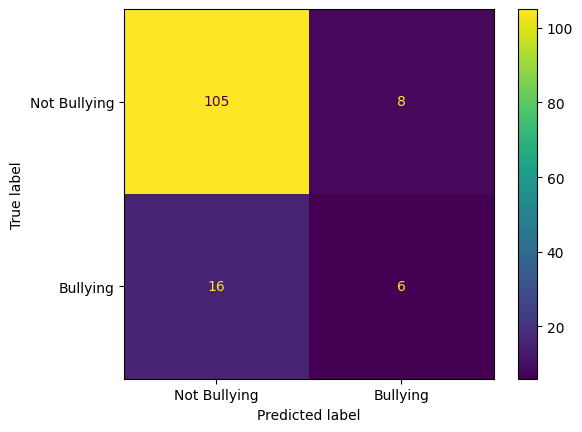

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Bullying", "Bullying"])
disp.plot()

In [29]:
df["id"] = df.index + 1
df["platform"] = "twitter" 
df["context"] = "Post from cyberbullying dataset"
df["user_age"] = "teen"

# no extra fields
export_df = df[["id", "clean_text"]]
export_df = export_df.rename(columns={"clean_text": "text"})


# Save as a newline-delimited JSON
export_df.to_json("cleaned_posts.json", orient="records", lines=True)